In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
%matplotlib notebook

# HERA Data Analysis Part I: Reading, Manipulating, and Visualizing Visibility Data  <a class="tocSkip">

### *Workshop Leaders: Bobby Pascua, Josh Dillon, and James Aguirre*  <a class="tocSkip">
#### (Originally developed by Carina Cheng & Josh Dillon)  <a class="tocSkip">

# Reading Files and Metadata

In this section, we'll go over how to read HERA data and some basic features of the `UVData` class that we will load the data into. For a detailed reference, you should browse [the pyuvdata documentation](https://pyuvdata.readthedocs.io/en/latest/). The examples covered here will use data from a small file prepared by Josh Dillon: `zen.2458098.40887.HH.calibrated_downselected.uvh5`.

In [2]:
sample_file = 'zen.2458098.40887.HH.calibrated_downselected.uvh5'
uvdata = UVData()
uvdata.read(sample_file)

This function loads in the metadata of the the data file when it's constructed. So for example, we can answer some questions:

* How many antennas are in the array and what are their antenna numbers? 

* How many frequency channels are there in the array. What range do they cover in MHz?

* How many time integrations are there in the file?


In [3]:
n_ants = uvdata.Nants_data  # Number of antennas with data associated with them.
n_ants_tot = uvdata.Nants_telescope  # Number of antennas in the array.
all_ants = uvdata.antenna_numbers
data_ants = set(uvdata.ant_1_array).union(uvdata.ant_2_array)

print(f"There are {n_ants_tot} antennas in the array, and they are:\n{all_ants}\n")
print(f"There are {n_ants} antennas with data, and they are:\n{data_ants}\n")

freqs_MHz = np.unique(uvdata.freq_array) / 1e6
fmin = freqs_MHz.min()
fmax = freqs_MHz.max()
print(f"There are {uvdata.Nfreqs} frequencies, covering {fmin:.2f} MHz to {fmax:.2f} MHz.\n")
print(f"There are {uvdata.Ntimes} integrations.")

There are 52 antennas in the array, and they are:
[136 140 121  88  41  86  36  51  50  98 123 124  65 137  82 120 143  66
  83 122  67  68  69  70  71  85   0   1  11  12  13  14   2  23  24  25
  26  27  37  38  39  40  52  53  54  55  84  87 141 138 142 139]

There are 6 antennas with data, and they are:
{65, 37, 38, 71, 83, 51}

There are 1024 frequencies, covering 100.00 MHz to 199.90 MHz.

There are 60 integrations.


## Exercise 1 

Now it's your turn. Try to answer these basic questions about the data:

1. What is the width of each frequency channel in MHz?

2. What range of Julian Dates do they span?

3. What is the lengh of each time integration in seconds?

4. What range of LSTs (local sidreal times) do the data span?

5. How many baselines are in the file? How many should there be? Why don't they agree? Hint: check the `history` attribute of the `UVData` object.

In [4]:
# your answers here (hint: look at the attributes of the UVData object)

print(f"1. The width of each frequency channel is {uvdata.channel_width / 1e3} kHz.\n")

times, inds = np.unique(uvdata.time_array, return_index=True)
lsts = uvdata.lst_array[inds]
lsts_hr = lsts * 12 / np.pi
print(f"2. The Julian Dates range from {times.min():.5f} to {times.max():.5f}.\n")

print(f"3. The integration time is {uvdata.integration_time[0]:.2f} seconds.\n")

print(f"4. The LSTs range from {lsts_hr.min():.5f} hours to {lsts_hr.max():.5f} hours.\n")

expected_n_bls = n_ants_tot * (n_ants_tot-1) // 2
print(f"5. There are {uvdata.Nbls} baselines, but there should be {expected_n_bls}.\n")

print(f"History for {sample_file}:\n{uvdata.history}")

1. The width of each frequency channel is 97.65625 kHz.

2. The Julian Dates range from 2458098.40893 to 2458098.41626.

3. The integration time is 10.74 seconds.

4. The LSTs range from 4.56346 hours to 4.73992 hours.

5. There are 3 baselines, but there should be 1326.

History for zen.2458098.40887.HH.calibrated_downselected.uvh5:
CORR-DACQ: created file.
  Read/written with pyuvdata version: 1.2.1.  Git origin: https://github.com/HERA-Team/pyuvdata.git.  Git hash: 2325220979539b351990bb5916e7dfd7246843c9.  Git branch: h1c.  Git description: v1.2-54-g2325220.  Downselected to specific antennas using pyuvdata. Hera Hex antennas selected with hera_cal/scripts/extract_hh.py, hera_cal version: {'git_hash': '5fb54895439cf3158c47209e2475b32dab67bdc8', 'version': '1.0', 'git_description': 'v1.0-21-g5fb5489', 'git_branch': 'h1c', 'git_origin': 'https://github.com/HERA-Team/hera_cal.git'}.
  Read/written with pyuvdata version: 1.3.7.  Git origin: https://github.com/HERA-Team/pyuvdata.git.  G

## Exercise 2 

Now let's plot our array to look at where the antennas are. (Hint, see what the `get_ENU_antpos` method does.)

<IPython.core.display.Javascript object>


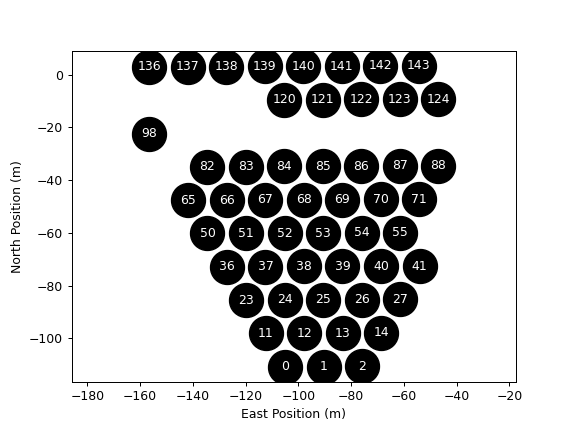

In [5]:
# Fill in the gaps in the code below:

# Get the antenna positions and numbers
antpos, antnums = uvdata.get_ENU_antpos()
east, north, up = antpos.T

plt.figure()
plt.scatter(east, north, marker='.', color='k', s=3000)  # plot the antenna positions with black circles
for i, ant in enumerate(antnums):  # loop over antennas
    plt.text(east[i], north[i], ant, color='w', va='center', ha='center')  # label antenna numbers
plt.xlabel('East Position (m)')
plt.ylabel('North Position (m)')
plt.axis('equal');

# Retrieving Data and Flags

In [6]:
# Check out what baselines and polarizations have data.
print(uvdata.get_antpairpols())

[(37, 38, 'xx'), (37, 38, 'yy'), (51, 83, 'xx'), (51, 83, 'yy'), (65, 71, 'xx'), (65, 71, 'yy')]


In [7]:
# Let's extract the data for a long East-West baseline
antpairpol = (65, 71, "xx")
data = uvdata.get_data(antpairpol)
flags = uvdata.get_flags(antpairpol)

In [8]:
# We're going to be applying flags to our data frequently
# So let's make a helper function for it
def apply_flags(data, flags, fill_value=np.nan+1j*np.nan):
    return np.where(flags, fill_value, data)

In [9]:
modified_data = apply_flags(data, flags)

<IPython.core.display.Javascript object>


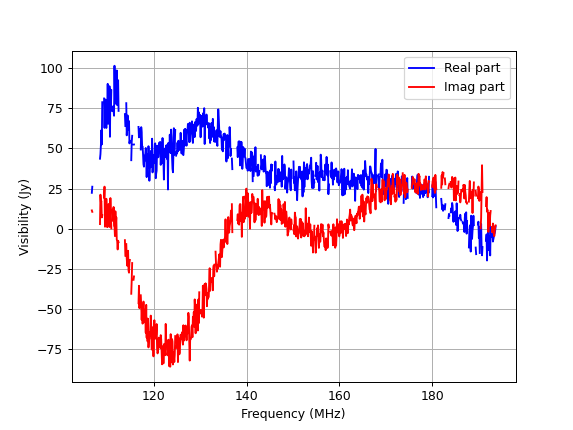

In [10]:
integration = 30 # this is the integration index, 30 out of 60 total integrations
plt.figure()
plt.plot(freqs_MHz, modified_data[integration].real, 'b-', label='Real part')
plt.plot(freqs_MHz, modified_data[integration].imag, 'r-', label='Imag part')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility (Jy)')
plt.grid(); plt.legend();

## Exercise 3
Plot unflagged visibilities as a function of LST for a few different frequency channels. Label each channel's frequency and include a legend.

<IPython.core.display.Javascript object>


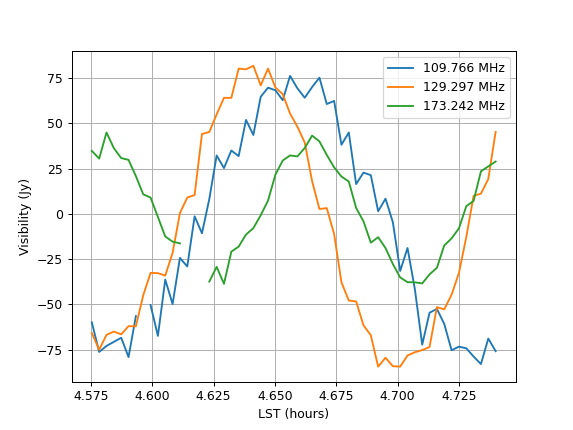

In [11]:
chans = [100,300,750]

# your answer here 
plt.figure()

for chan in chans:
    freq = freqs_MHz[chan]
    plt.plot(lsts_hr, modified_data[:,chan].real, label=f"{freq:.3f} MHz") 
plt.xlabel('LST (hours)')
plt.ylabel('Visibility (Jy)')
plt.grid(); plt.legend();

# Waterfall Plots

## Exercise 4

(in breakout groups)

Recall that

$\LARGE{V_{ij}(\nu) = \int B_{ij}(\mathbf{\hat{r}}, \nu) I(\mathbf{\hat{r}},\nu) e^{-(2 \pi i \nu / c)(\mathbf{b_{ij}}\cdot \mathbf{\hat{r}})}} d\Omega$.


For simplicity, imagine that we have a two-element interferometer sitting on the equator of the earth with the two antennas separated by a vector that is perfectly aligned with the east-west direction. Make a sketch of what you think the phase of a visibility should look like, as a function of time if the sky contains a single source is located at zero-declination (is transiting through the zenith of the celestial sphere). 

Make another sketch of how the phase should evolve if the pair of antennas are aligned perfectly in the north-south direction. 

How would you expect the phase evolution of a longe EW baseline to compare to the phase evolution of a short EW baseline?

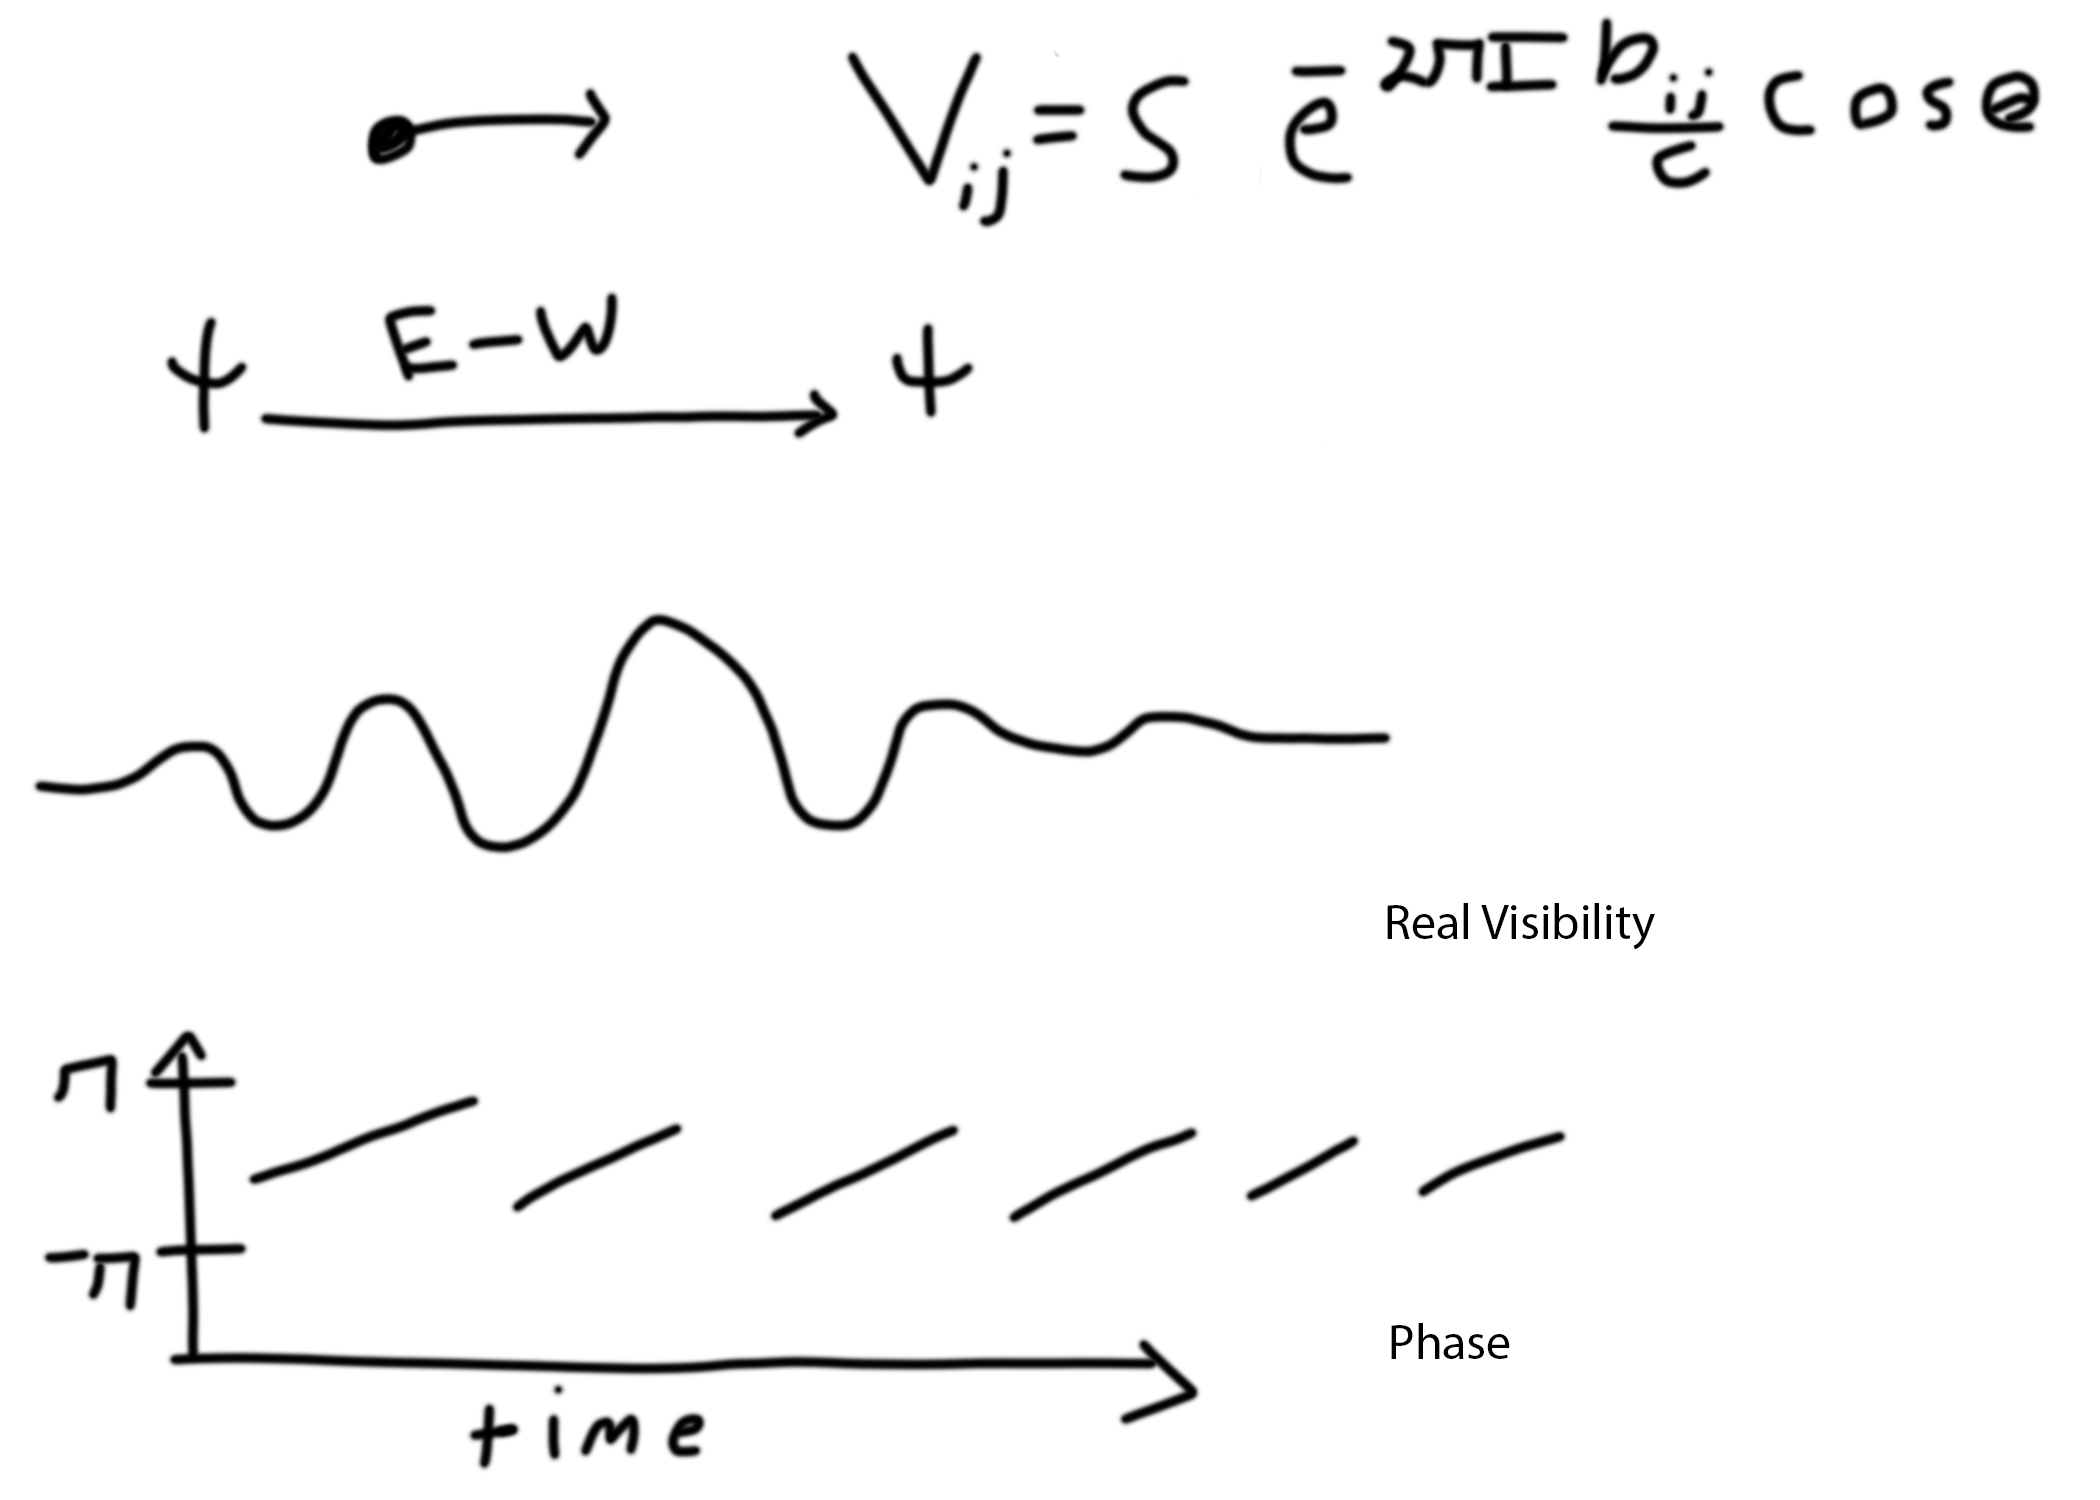

In [12]:
from IPython.display import Image
Image('visibility_phase_sketch_EW.png')

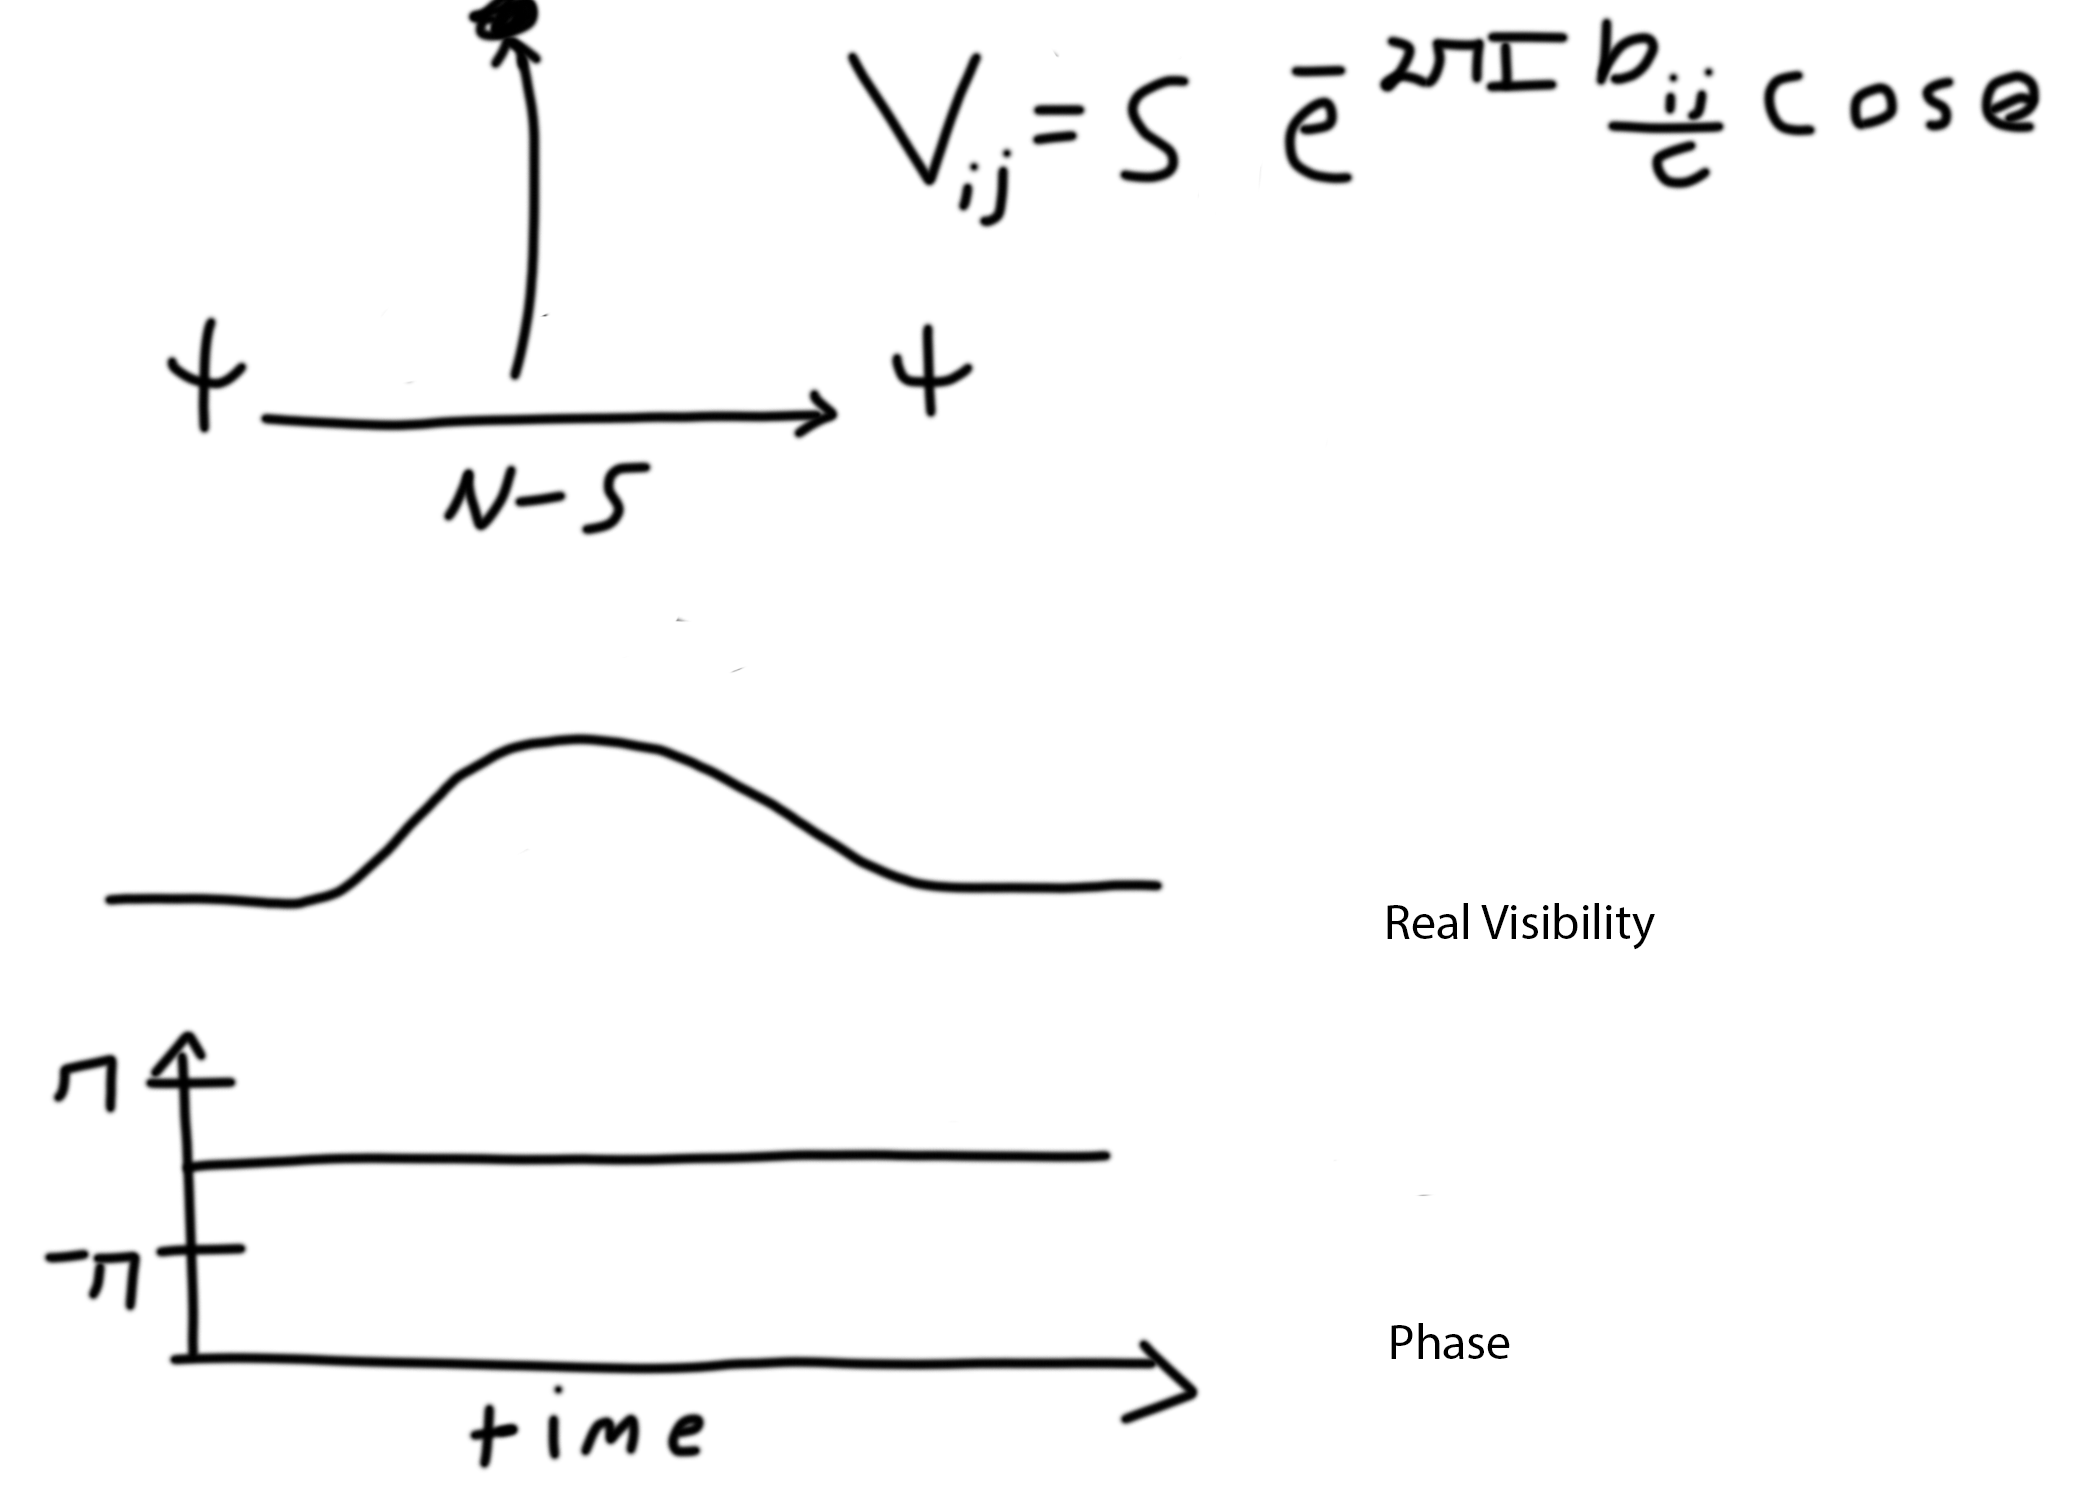

In [13]:
from IPython.display import Image
Image('visibility_phase_sketch_NS.png')

**Now Make a Waterfall**

Another useful way of visualizing our data is to plot it as a waterfall plot. A waterfall plot is a two-dimensional plot of the visibility (the cross-correlated signal between a pair of antennas) as a function of time (y-axis) and frequency (x-axis). We can use the `plt.imshow` to plot the amplitude and phase of the same baseline as above. Note that the keyword `extent` takes in 4 arguments which define the plot axes extent in the order of (xmin, xmax, ymin, ymax), and we've massaged our axes to display frequencies in MHz and times in LST hours.

In [14]:
# Before we make any plots, let's figure out some extra things to make pretty plots.
# Let's use a logarithmic colormap for visualizing the visibility amplitude
vmin = np.abs(data[~flags]).min()  # Get the smallest non-flagged visibility amplitude
vmax = np.abs(data[~flags]).max()  # and the largest
norm = plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax)  # This will tell the plotter how to format the colorbar

# The extent of a plot is [left, right, bottom, top]
# Remember that imshow has the vertical axis increasing downward!
extent = [freqs_MHz[0], freqs_MHz[-1], lsts_hr[-1], lsts_hr[0]]

# We'll be making lots of amplitude/phase waterfalls, but will keep lots of the
# parameters the same, so let's make it so we don't have to type so much
amp_plot_kwds = dict(
    aspect="auto",  # Use a nice setting for the aspect ratio
    norm=norm,  # How to map values to colors
    interpolation="none",  # How to fill in the space between data points
    extent=extent,  # Bounds of each axis
)
phs_plot_kwds = dict(aspect="auto", cmap="twilight", interpolation="none", extent=extent)

<IPython.core.display.Javascript object>


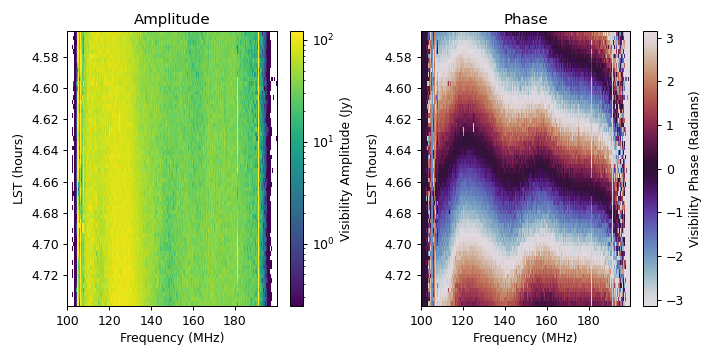

In [15]:
# Plot absolute value of visibility
plt.figure(figsize=(8,4))
plt.subplot(121)  # Use 1 row and 2 columns of plots; select the left plot
plt.imshow(np.abs(data), **amp_plot_kwds)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude')

# Plot phase of visibility
plt.subplot(122)  # Now select the right plot
plt.imshow(np.angle(data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase')

plt.tight_layout();

Some features to note from the waterfall plots:
* RFI
* Band edges
* Frequency and temporal structure

Thankfully, someone has already done a bunch of work to figure out which data might be bad and flagged it. Here is what the flags look like:

<IPython.core.display.Javascript object>


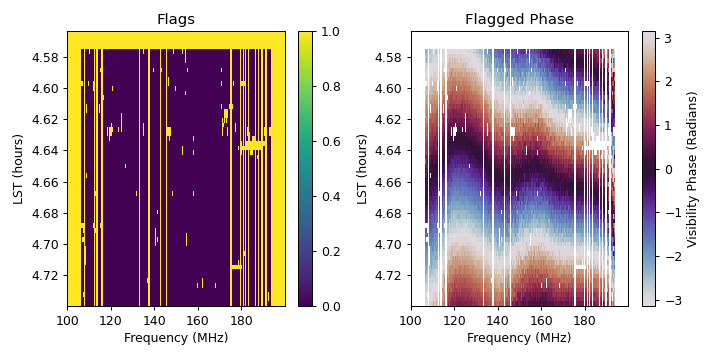

In [16]:
# Plot RFI Flags
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(flags.astype(float), aspect='auto', interpolation='none', extent=extent)
plt.colorbar()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Flags')

# Plot phase of visibility
plt.subplot(122)
plt.imshow(np.angle(modified_data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Flagged Phase')

plt.tight_layout();

## Exercise 5
Exercise: Now try a short baseline and a long baseline of the same orientation. Make waterfall plots (in both amplitude and phase) for both. How do they differ?

<IPython.core.display.Javascript object>


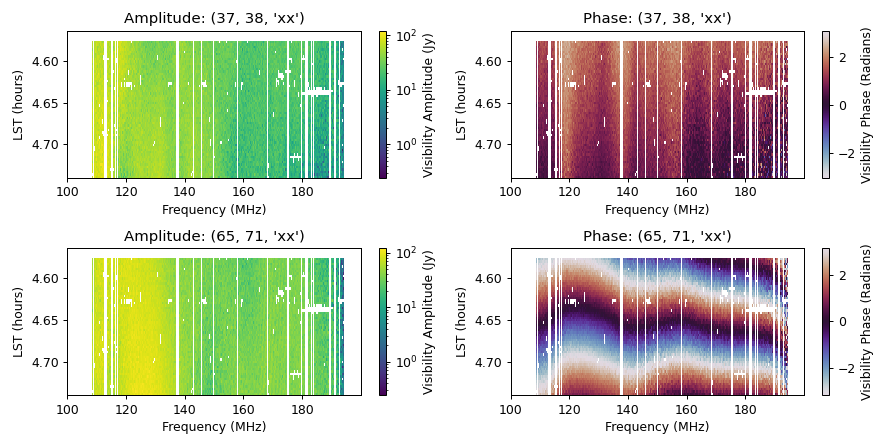

In [17]:
short_ew_bl = (37, 38, 'xx')
long_ew_bl = (65, 71, 'xx')
short_ew_data = uvdata.get_data(short_ew_bl)
short_ew_flags = uvdata.get_flags(short_ew_bl)
modified_short_data = apply_flags(short_ew_data, short_ew_flags)
long_ew_data = uvdata.get_data(long_ew_bl)
long_ew_flags = uvdata.get_flags(long_ew_bl)
modified_long_data = apply_flags(long_ew_data, long_ew_flags)

# your answer here
plt.figure(figsize=(10,5))
plt.subplot(221)  # Make a figure with two rows and two columns; choose the top-left plot
plt.imshow(np.abs(modified_short_data), **amp_plot_kwds)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Amplitude: {short_ew_bl}')

plt.subplot(222)  # Choose the top-right plot
plt.imshow(np.angle(modified_short_data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Phase: {short_ew_bl}')

plt.subplot(223)  # Choose the bottom-left plot
plt.imshow(np.abs(modified_long_data), **amp_plot_kwds)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Amplitude: {long_ew_bl}')

plt.subplot(224)  # Choose the bottom-right plot
plt.imshow(np.angle(modified_long_data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Phase: {long_ew_bl}')

plt.tight_layout();

## Exercise 6
Now try comparing a N/S baseline to a E/W one of similar lengths do the waterfall plots differ for an E/W baseline vs. a N/S baseline? Does their difference make sense? 

<IPython.core.display.Javascript object>


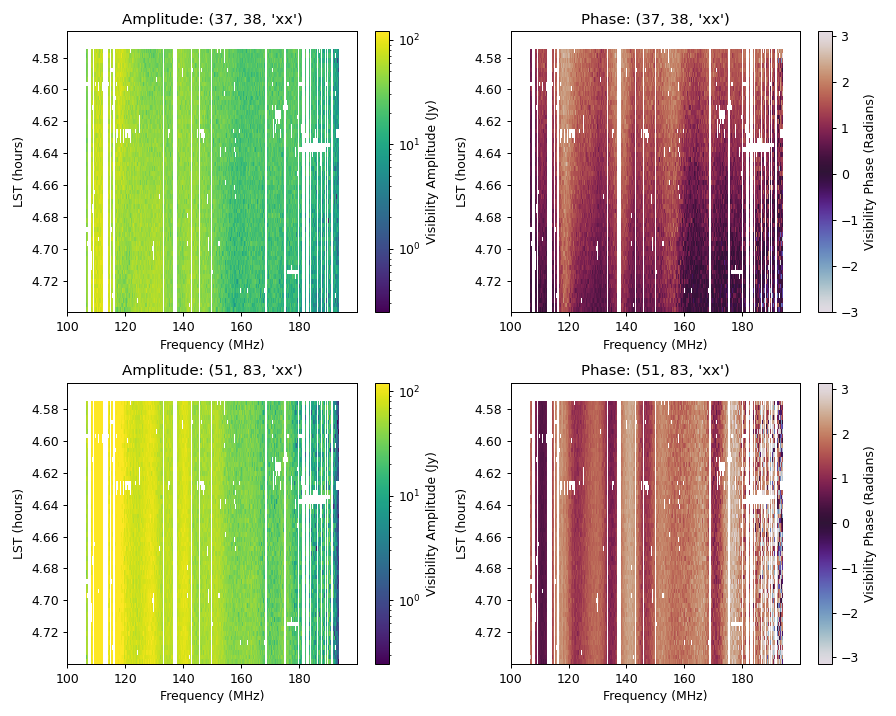

In [18]:
ns_bl = (51, 83, 'xx')
ew_bl = (37, 38, 'xx')
ns_data = uvdata.get_data(ns_bl)
ns_flags = uvdata.get_flags(ns_bl)
modified_ns_data = apply_flags(ns_data, ns_flags)
ew_data = uvdata.get_data(ew_bl)
ew_flags = uvdata.get_flags(ew_bl)
modified_ew_data = apply_flags(ew_data, ew_flags)

# your answer here
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(np.abs(modified_ew_data), **amp_plot_kwds)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Amplitude: {ew_bl}')

plt.subplot(222)
plt.imshow(np.angle(modified_ew_data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Phase: {ew_bl}')

plt.subplot(223)
plt.imshow(np.abs(modified_ns_data), **amp_plot_kwds)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Amplitude: {ns_bl}')

plt.subplot(224)
plt.imshow(np.angle(modified_ns_data), **phs_plot_kwds)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title(f'Phase: {ns_bl}')

plt.tight_layout();

# The Delay Transform

The delay transform is a clever technique we use to isolate bright foregrounds in our data (which we can then filter out). The delay transform is simply the Fourier transform of the visibility along the frequency axis.

## Exercise 7

(breakout groups)

At a fixed time, our data should have two contributions: smooth foregrounds (that occupy small delays) and noise (that occupies many delays). As a group, make a sketch of what you would expect the frequency-to-delay Fourier transform of this data to look like a single time. 

**Solution Exercise 7**

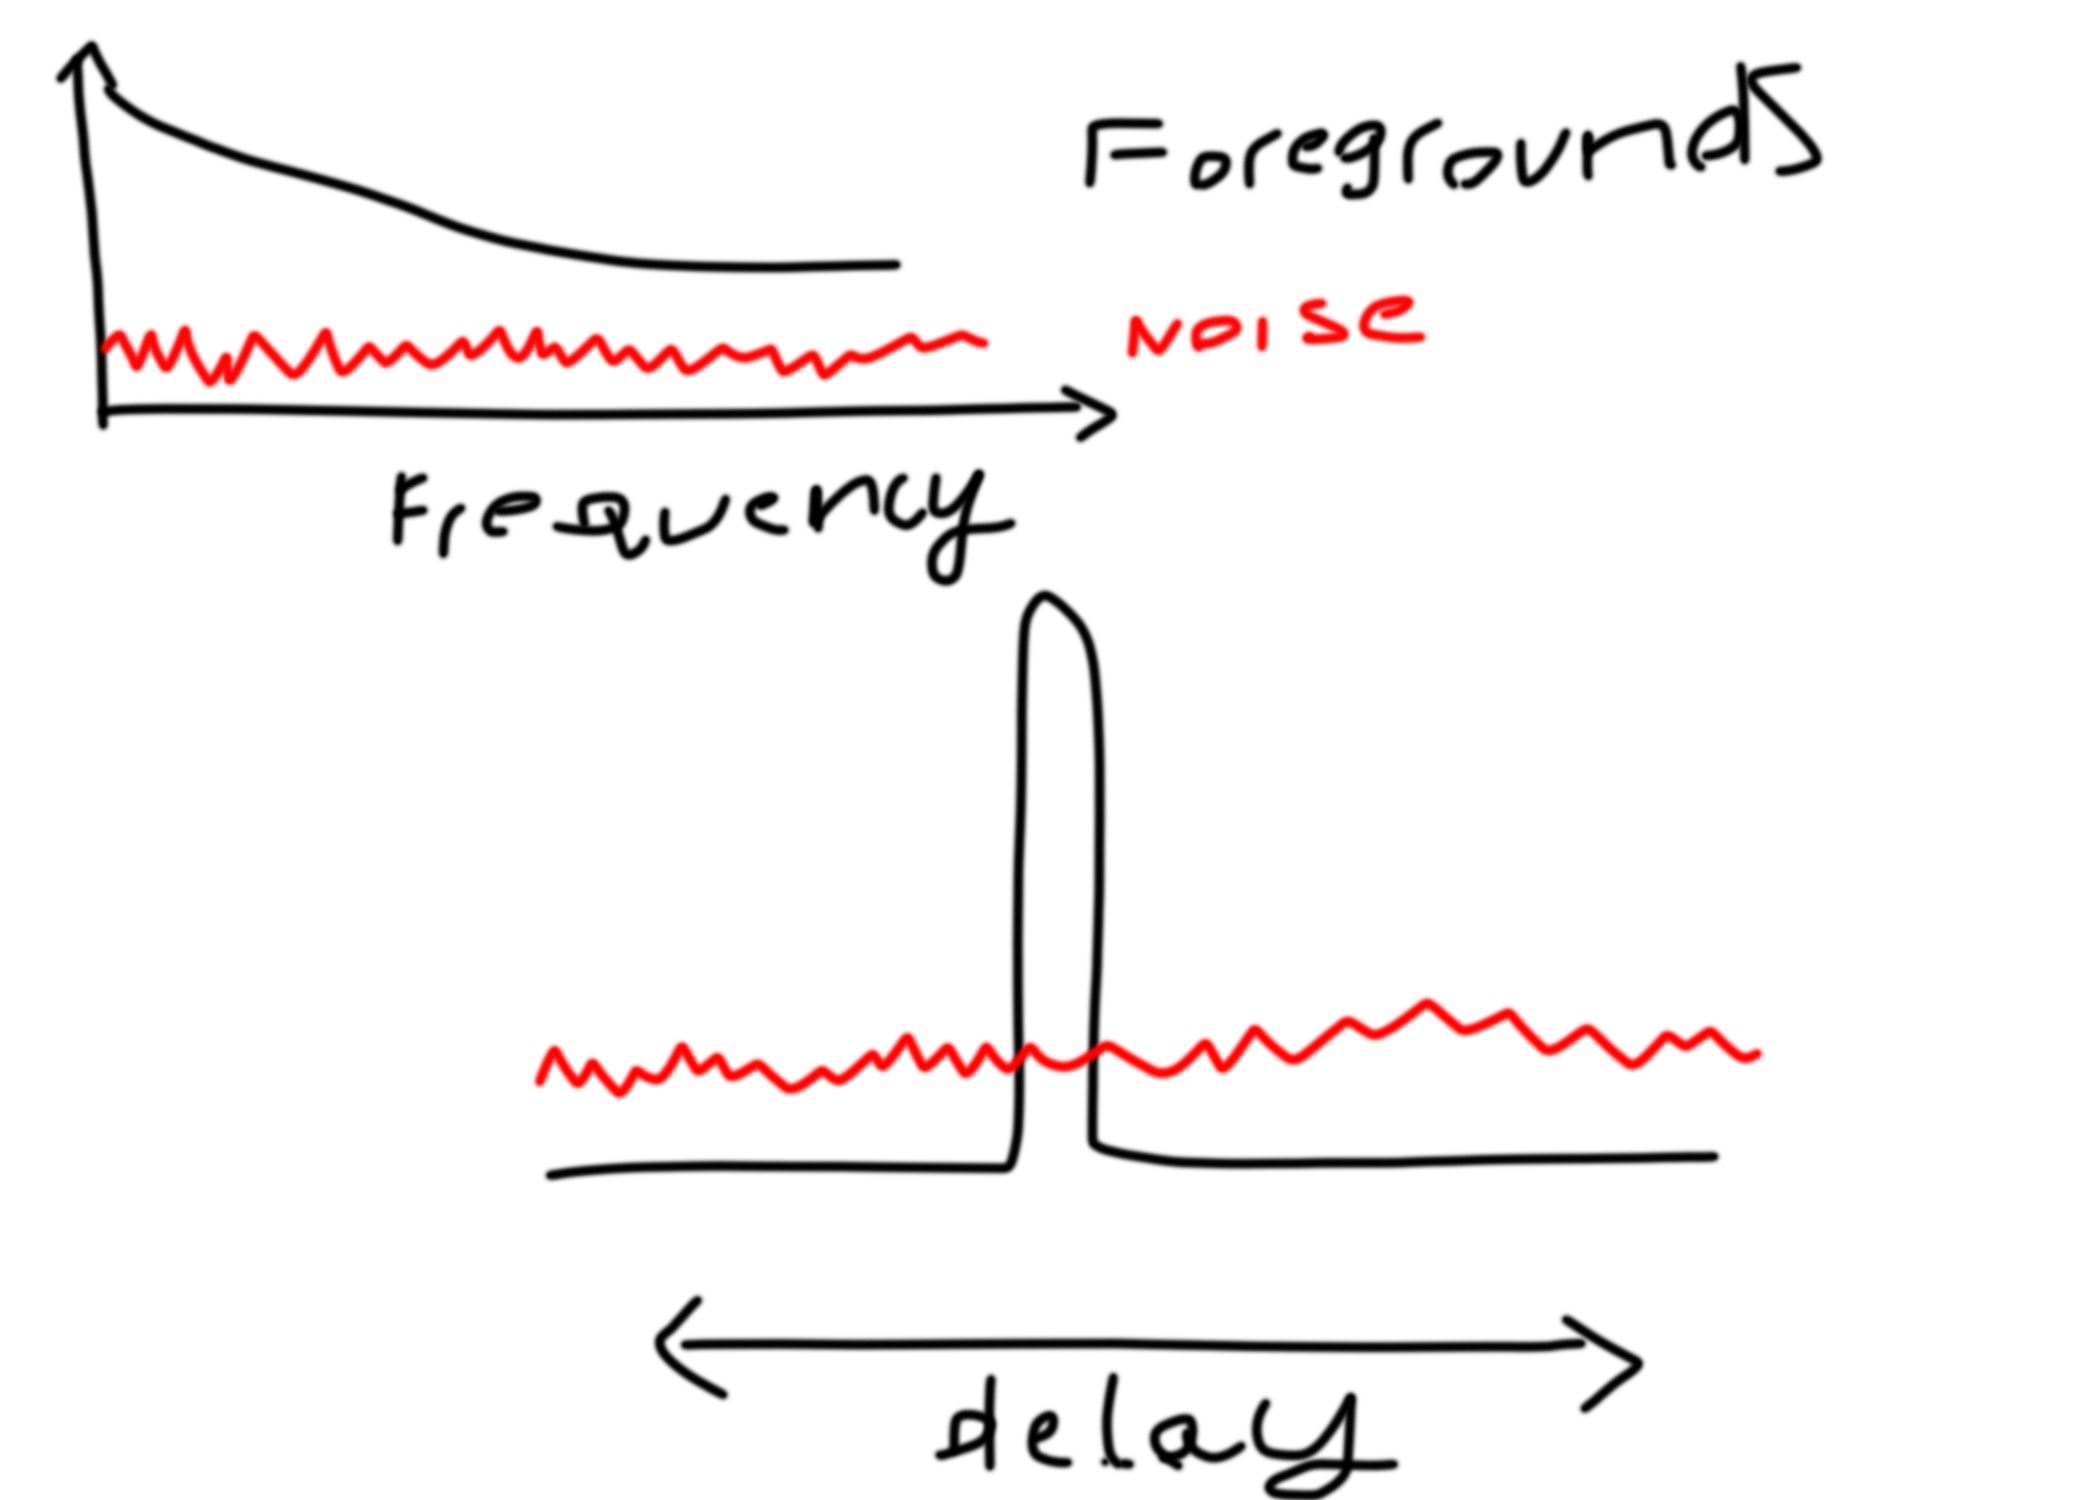

In [19]:
from IPython.display import Image
Image('smooth_power_spectrum.png')


## Exercise 8

Try implementing the delay transform using `np.fft.fft` by following the steps below.

<IPython.core.display.Javascript object>


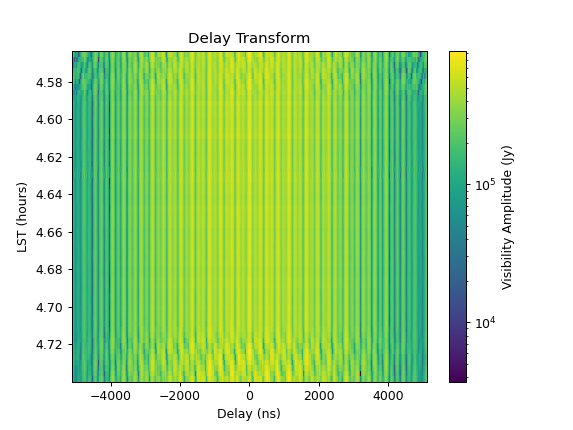

In [20]:
bl = (51,83,'xx')
vis = uvdata.get_data(bl)

# 1) Fourier transform "vis" along the frequency axis (don't forget to fftshift after)
vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1), axes=1) # Fourier-transform along frequency

# 2) Find the frequency width of a channel in GHz
freq_width =  uvdata.channel_width / 1e9  # GHz

#3) Convert frequencies to delays. Numpy's fftfreq function takes two arguments: 
#   the number of frequencies, and the frequeny width you calculated above
delays = np.fft.fftshift(np.fft.fftfreq(uvdata.Nfreqs, freq_width)) # ns
vmin = np.abs(vis_dt).min()
vmax = np.abs(vis_dt).max()
norm = plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax)
new_extent = [delays[0], delays[-1], lsts_hr[-1], lsts_hr[0]]

plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=norm, interpolation='none', extent=new_extent)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');

## Exercise 9


Does this waterfall match your expectations? 

The delay transform looks a lot like a sinusoid. 

What is the Fourier tranform of a sinusoid? 

Can you identify this source of this sinusoid in the time-frequency waterfall of the data? Hint: use a linear colorscale ranging from about 0 to 1000. 

What do you think causes these features?

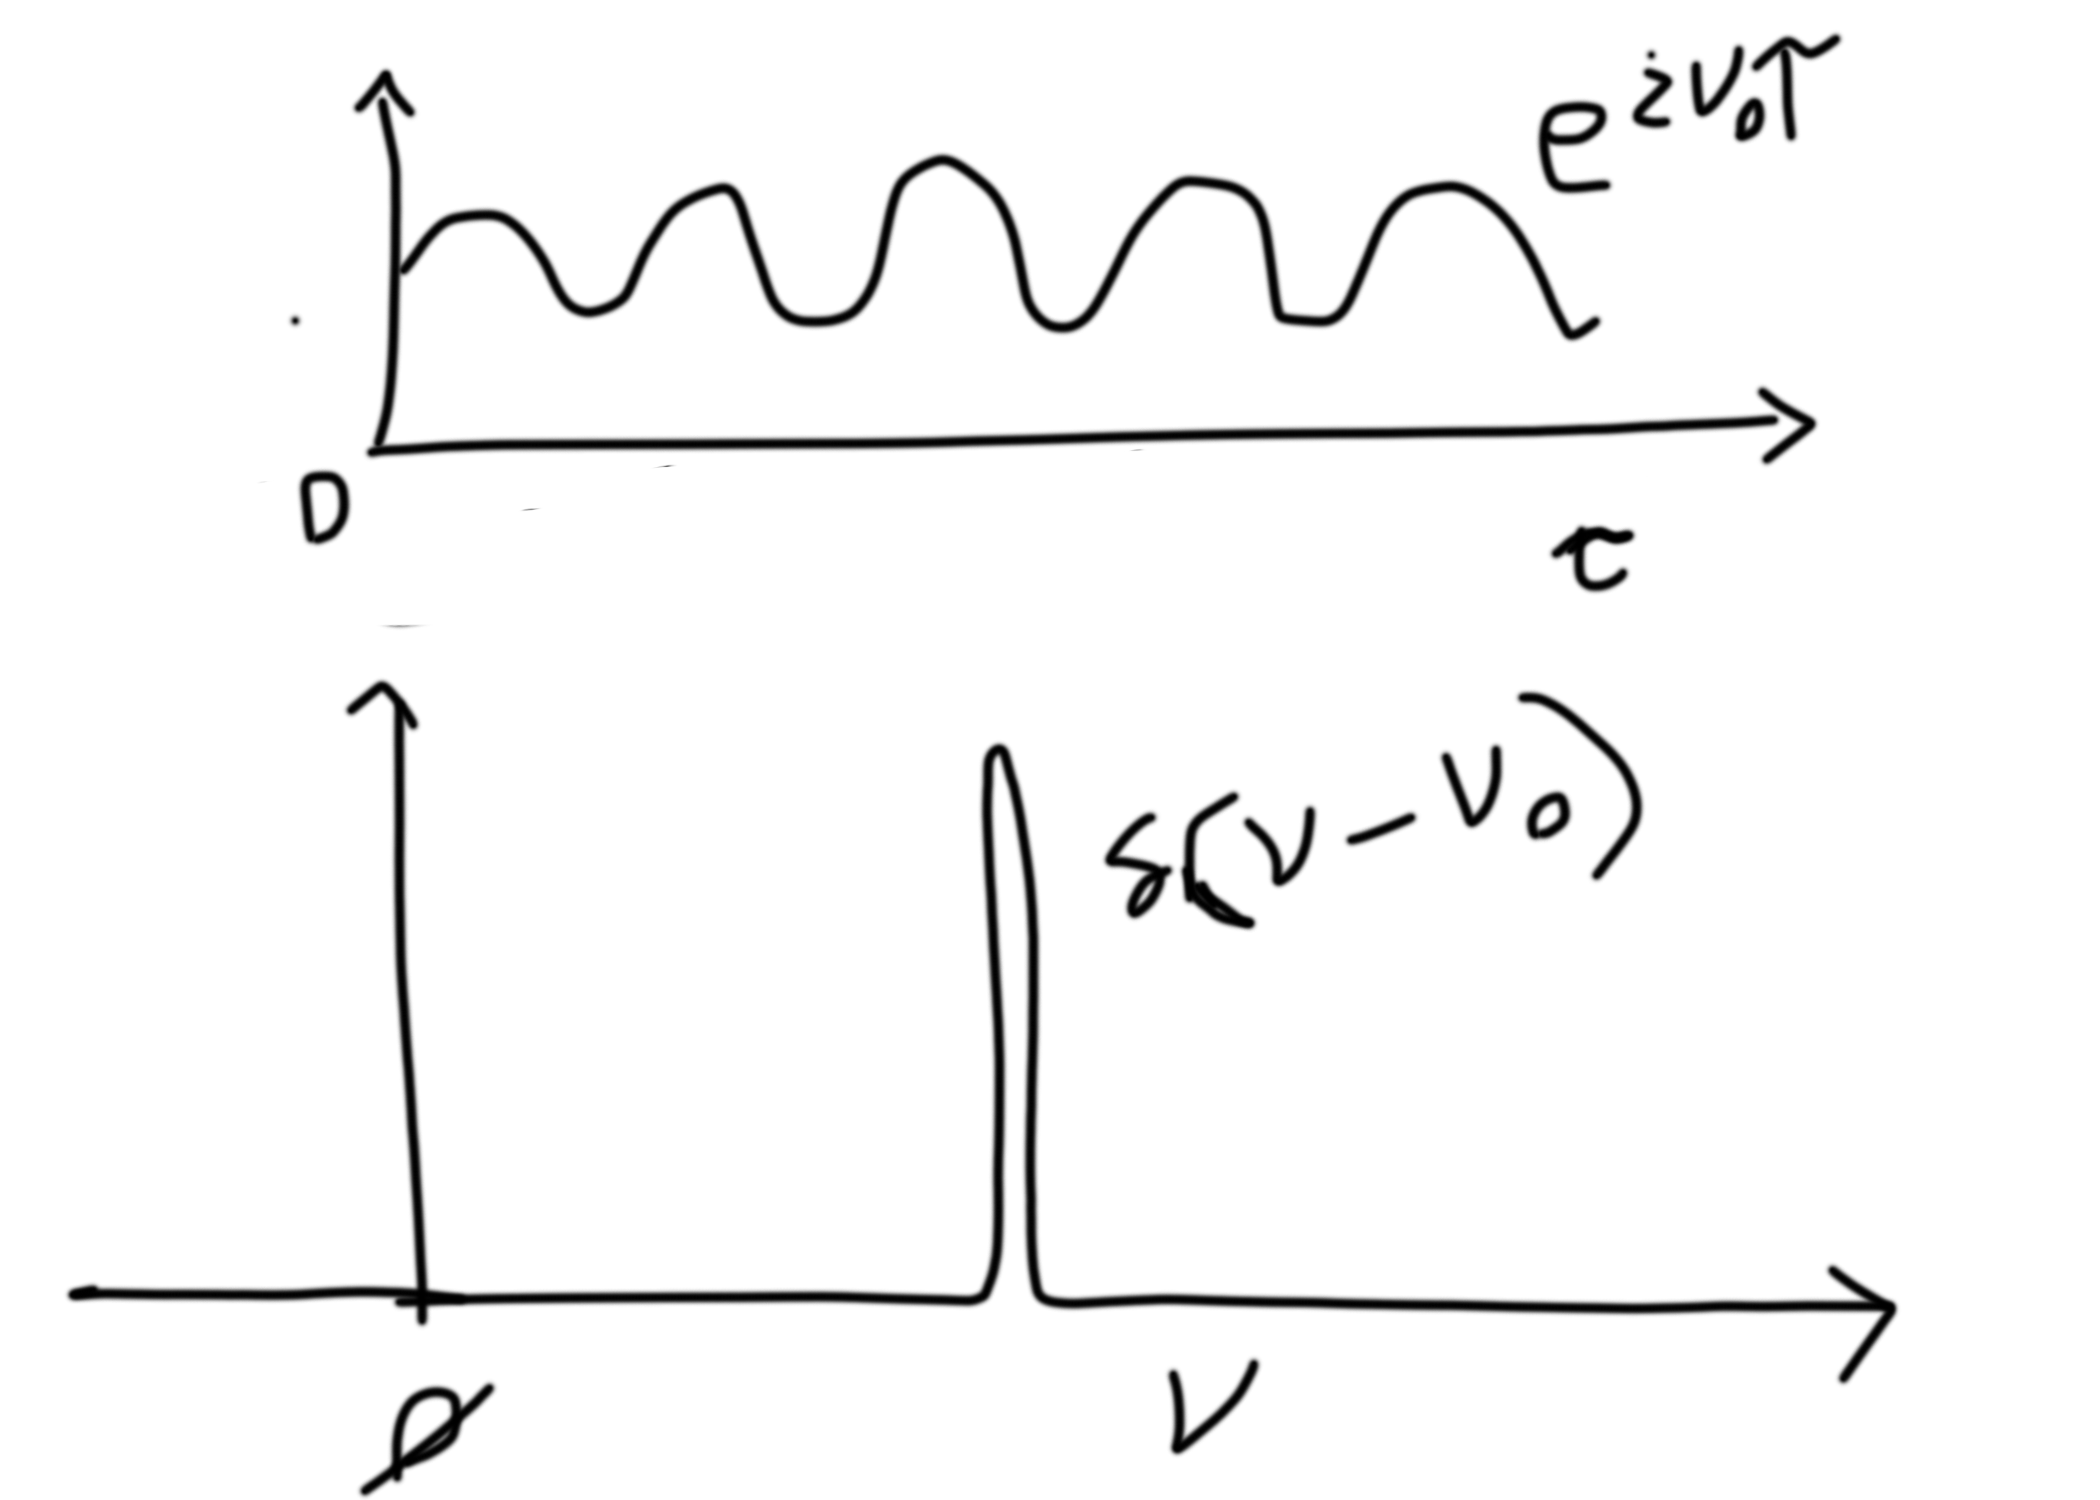

In [21]:
from IPython.display import Image
Image('sinusoid_fourier_transform.png')

<IPython.core.display.Javascript object>


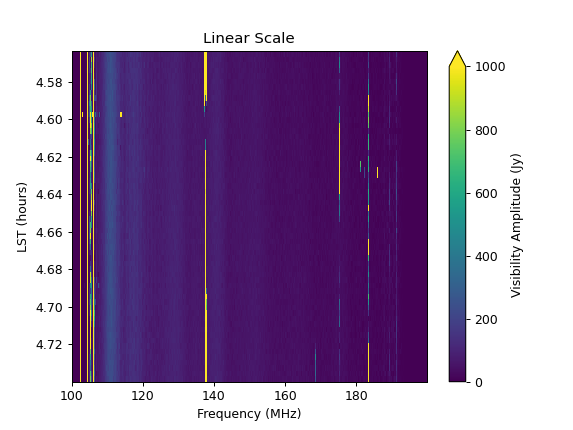

In [22]:
# your answer here
plt.figure()
plt.imshow(np.abs(vis), aspect='auto', vmin=0, vmax=1e3, interpolation='none', extent=extent)
plt.colorbar(label='Visibility Amplitude (Jy)', extend='max')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Linear Scale');

**Solution:**

Recall that the Fourier transform of a sinusoid is a delta-function. Thus, if we look at the time-**frequency** waterfall, we should expect to see some delta-function like features. Indeed, we do see a number of such spiky prominences in the above plot. 

These spikes are narrowband Radio Frequency Interference (RFI)&mdash;things like FM radio stations and satellite communications signals.

## Exercise 10

If we set the values of the channels where there is RFI to zero, what do you think the delay-transformed data would look like?

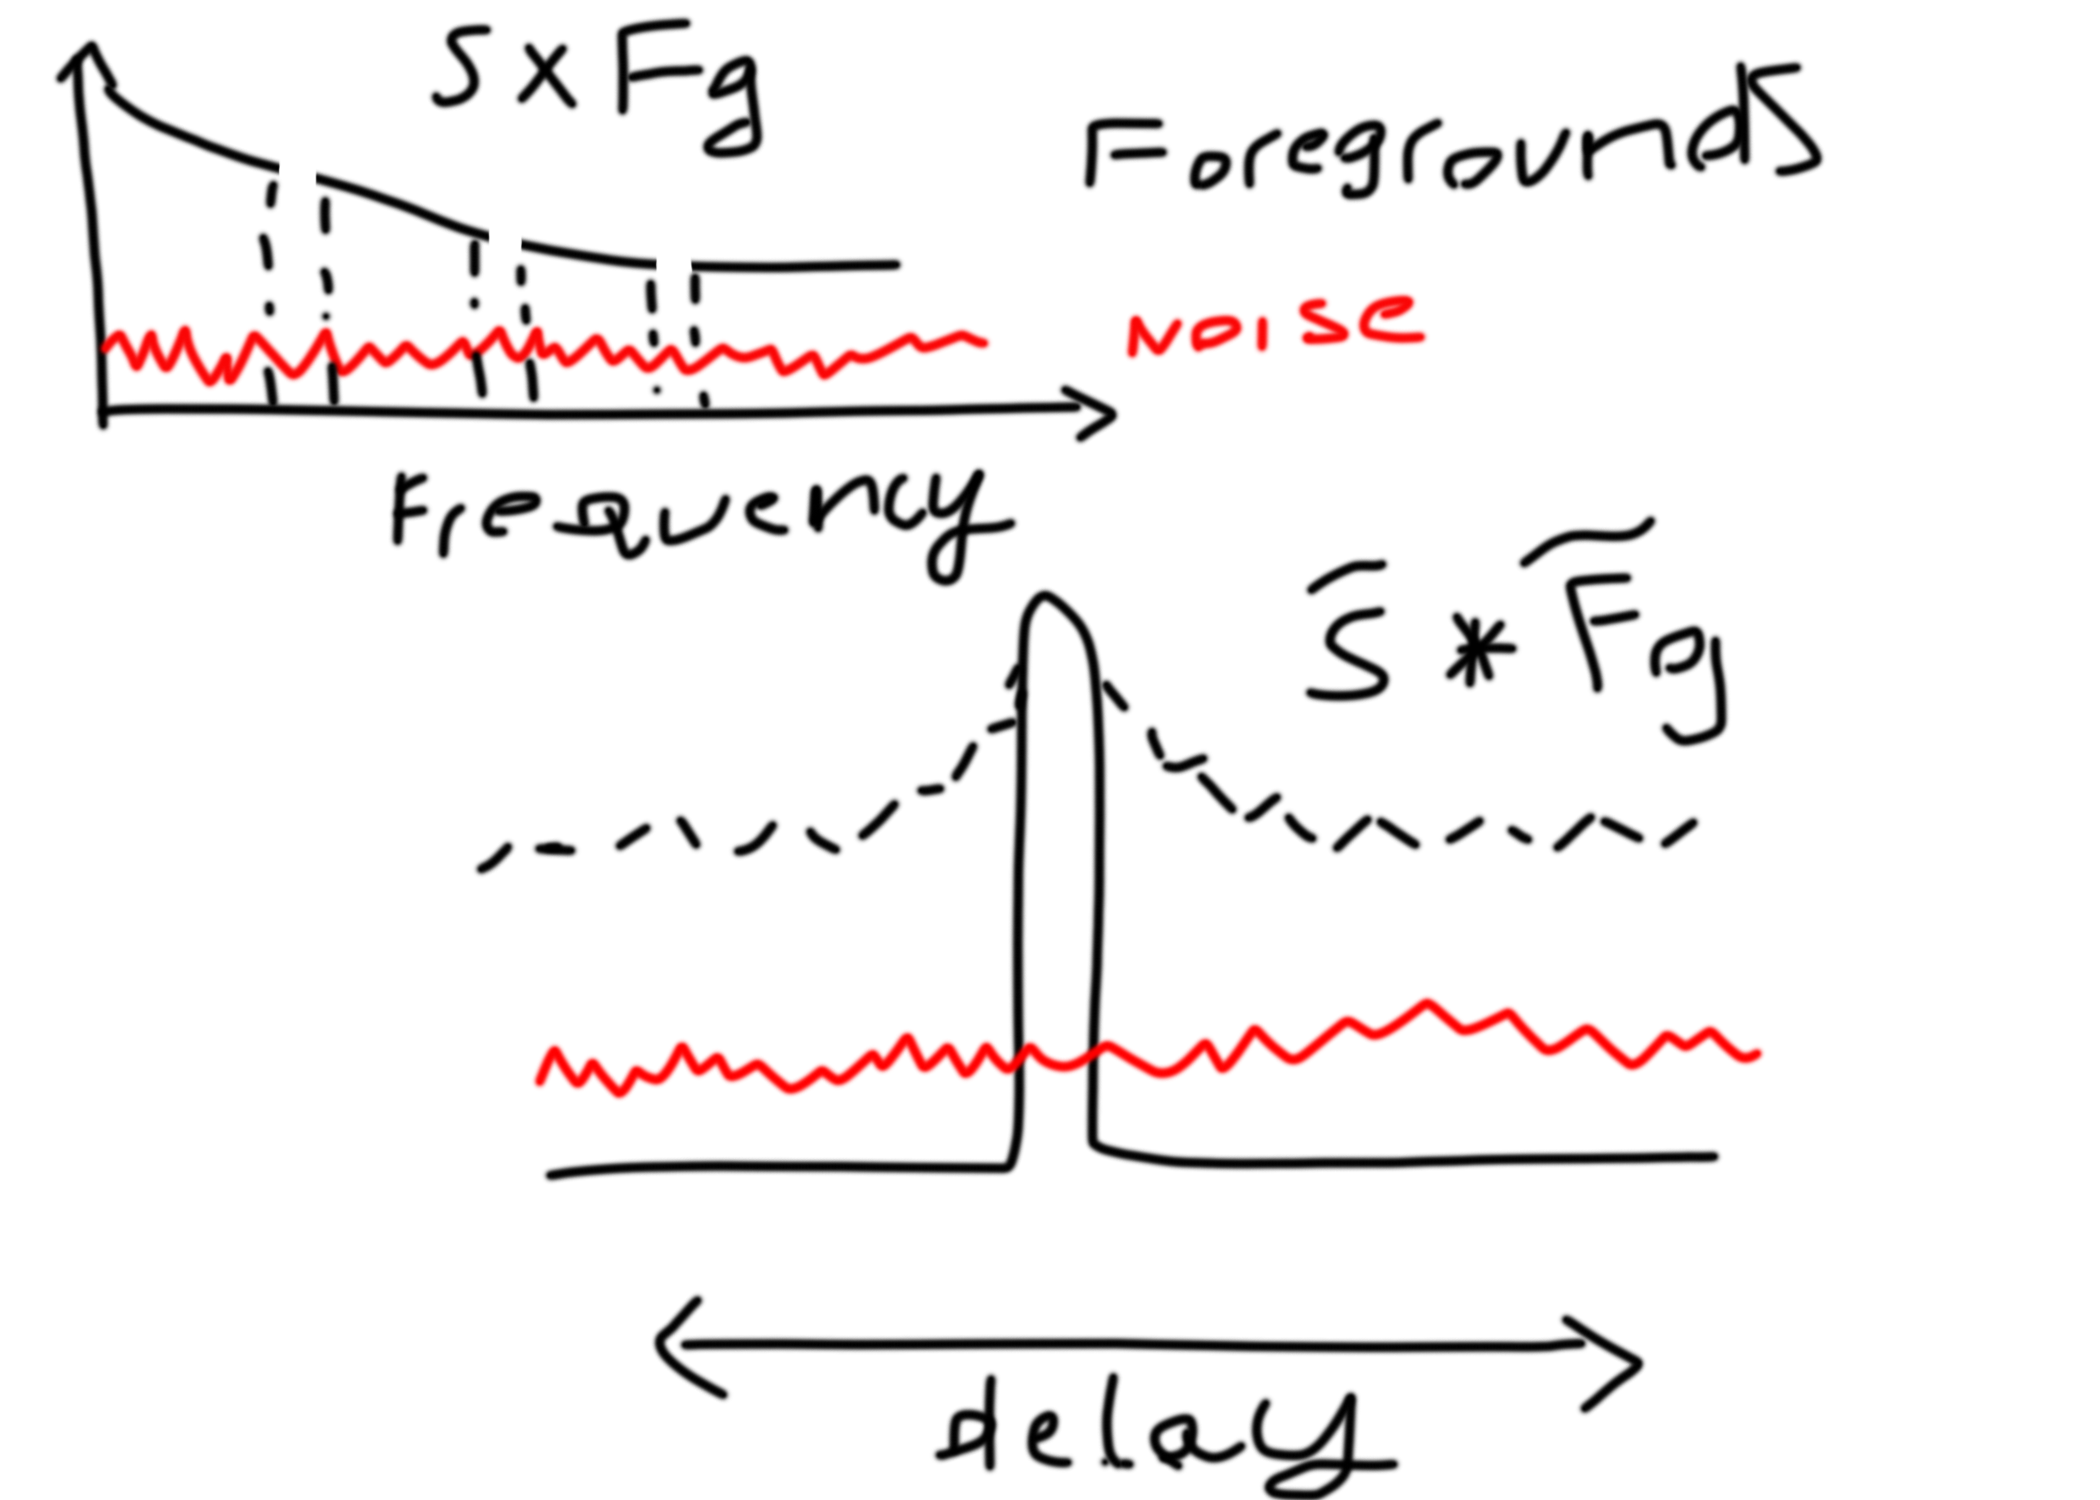

In [23]:
from IPython.display import Image
Image('smooth_power_spectrum_gaps.png')

## Exercise 11

Now plot the delay transform again, but this time set the flagged channels to 0 before taking the delay transform.

<IPython.core.display.Javascript object>


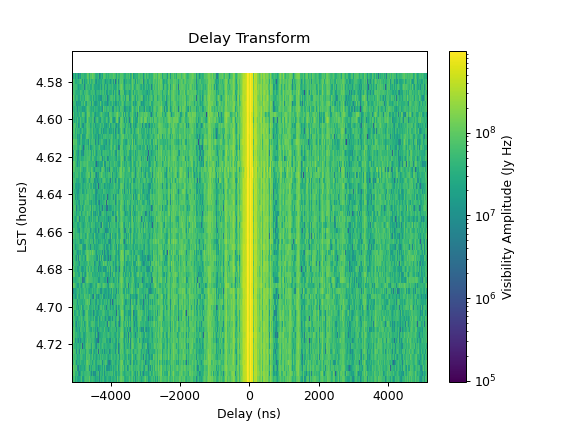

In [24]:
# your answer here
vis = apply_flags(ns_data, ns_flags, fill_value=0j)
vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1), axes=1) # Fourier-transform along frequency
vis_dt *= uvdata.channel_width
vmin = uvdata.channel_width
vmax = 1e4 * vmin
norm = plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax)

plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=norm, interpolation='none', extent=new_extent)
plt.colorbar(label='Visibility Amplitude (Jy Hz)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');

That's better. So what do we see here? All the bright stuff at low delay values correspond to bright foreground sources that are smooth in frequency (and therefore "peaky" in delay). This is nice for us because we've isolated the foregrounds and we can filter them out easily in this space.

Let's think about what "delay" means physically. A delay can be thought of as the time difference between when a lightwave hits one antenna and when it hits the second antenna. In other words, there is a time lag between light hitting each antenna depending on the direction it comes from and the orientation of the baseline.

Where would the light have to be coming from for the time delay to be zero? Where would it need to be coming from to produce a maximum delay (hint: we call this the horizon limit)?

## Exercise 12
For the baseline we picked earlier, calculate the theoretical maximum delay (in nanoseconds), using $t = d/c$, where $t$ is the time delay, $d$ is the baseline distance, and $c$ is the speed of light. You can calculate the baseline distance using the saved `antpos` and `ants` variables from earlier, or approximate it using the antenna layout plot.

In [25]:
# your answer here
ant1, ant2 = ns_bl[:2]
print(f'Antennas: {ant1}, {ant2}')

antpos_dict = dict(zip(antnums, antpos))
bl_len = np.linalg.norm(antpos_dict[ant2] - antpos_dict[ant1])
print(f'Baseline length: {bl_len:.2f} m')

c = 3e8 # speed of light in m/s
delay = bl_len / c * 1e9 # time delay in ns
print(f'Time Delay: {int(delay)} ns')

Antennas: 51, 83
Baseline length: 25.30 m
Time Delay: 84 ns


A cool trick for a faster calculation is to convert your distance $d$ to feet. That number is also approximately the time delay in nanoseconds! 

Also note that the foregrounds in our delay-transform plot spread out past this horizon limit. This is due to all sorts of effects, but the biggest one is the RFI gaps. However, we have algorithms that can deal with these in a smarter way than just setting them to 0. 

# Delay-Filtering&mdash;Interpolating the RFI gaps

While our waterfall in exercise 11 is certainly an improvement over leaving the RFI spikes in, the ringing structures that are caused by RFI gaps are only roughly a factor of 10-100 times lower than the foreground amplitude and cover all delays. We can think of these features as being an extra-nasty window function that corresponds to a top-hat window but now with gaps in it. This window function convolves our foregrounds and smears them to all delays. 

The 21-cm signal is ~$10^4$ smaller than the foregrounds, so the 1-10% flagging side-lobes are still a huge problem. 

One way to fix this is to use a delay <b>CLEAN</b>ing. Delay <b>CLEAN</b> is an algorithm that fits the data to complex sinusoids (with the same wavelengths as the wavelengths that we expect the foregrounds to have) and uses these sinusoids to interpolate foreground values in the flagged RFI channels. By performing this in-painting, we can eliminate the flagging side-lobes from exercise 11. 


We call the collection of sinusoids used to interpolate our data **CLEAN components** or our **CLEAN model**. Data that has been interpolated with these sinusoids is **CLEANed data**. 

Since we don't actually care about the foregrounds, we can also just subtract our fitted CLEAN components from the data. 

Here is how you can apply the delay-filtering code used by HERA to your data. 

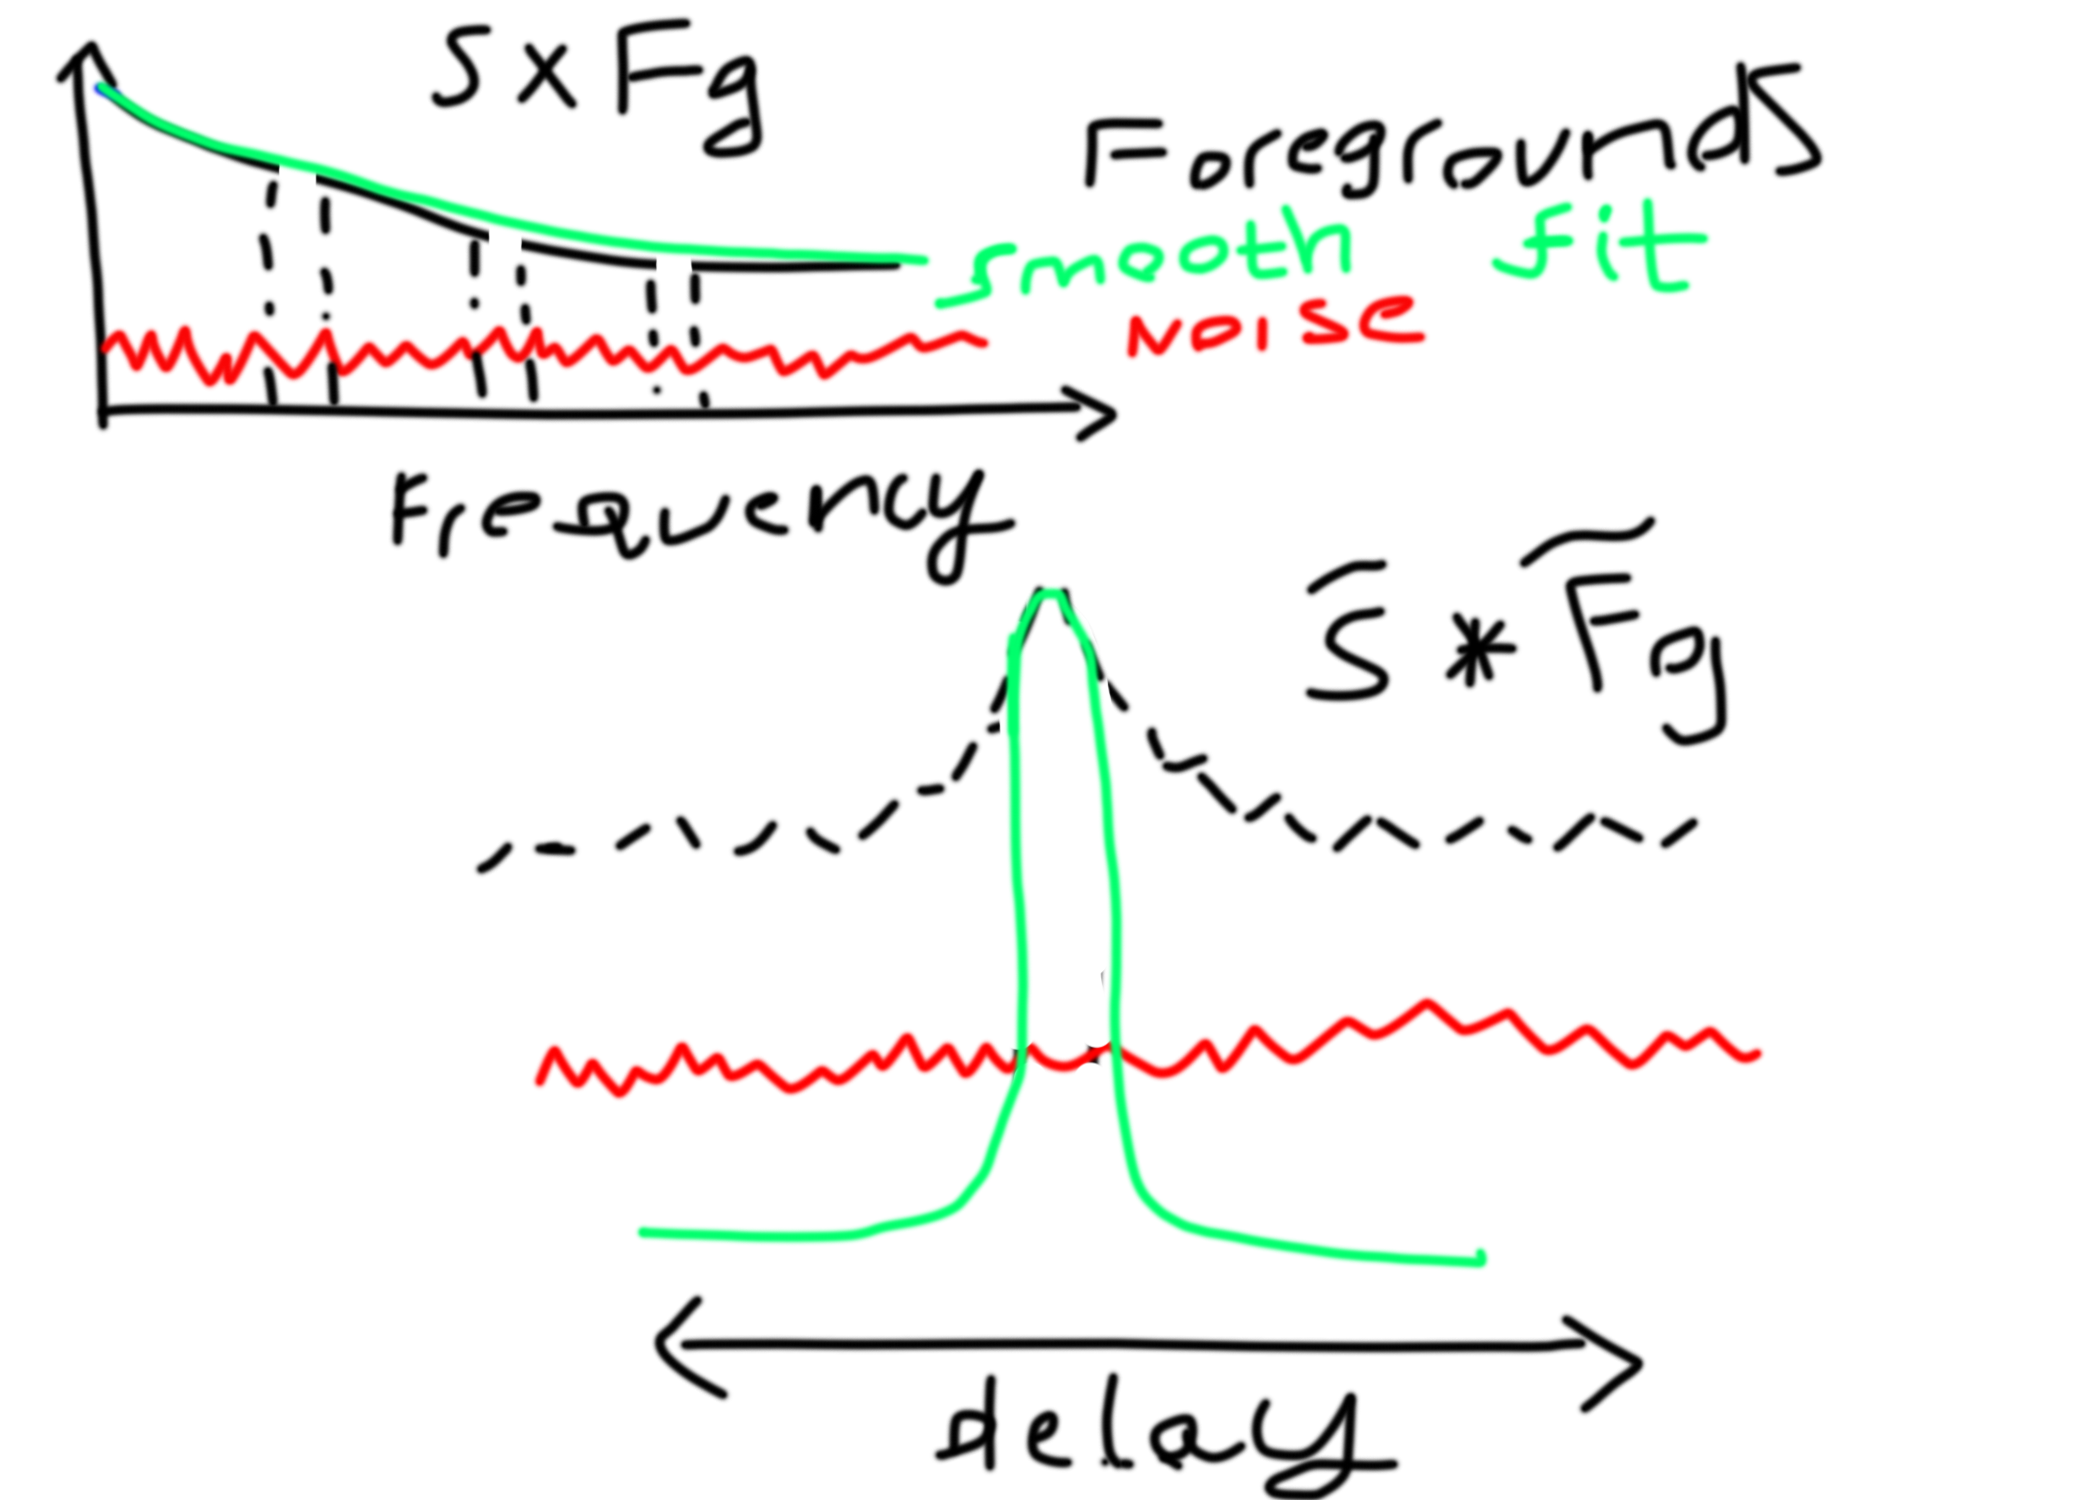

In [26]:
from IPython.display import Image
Image('smooth_power_spectrum_gaps_clean.png')

<IPython.core.display.Javascript object>


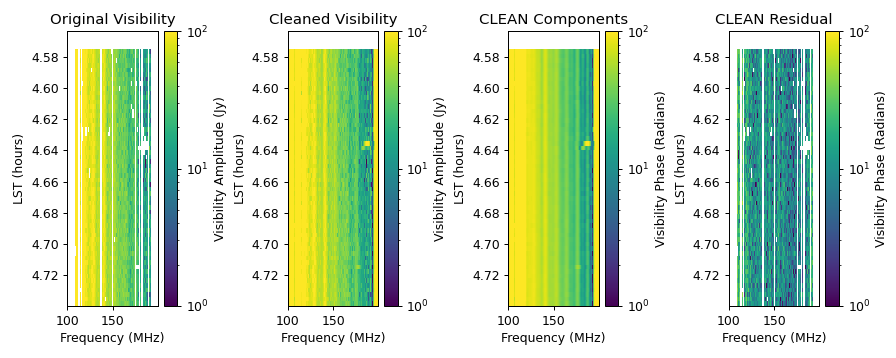

divide by zero encountered in true_divide
invalid value encountered in true_divide


In [27]:
from hera_cal import delay_filter
from hera_cal.io import HERAData
import matplotlib
hd = HERAData(sample_file)
data, flags, nsamples = hd.read()

bl = (51,83,'xx')
df = delay_filter.DelayFilter(hd) # establish delay filter object
df.run_filter(to_filter=[bl]) # filter the specific key we want (otherwise it takes a long time to do all keys)

clean_data = df.clean_data[bl] # filtered visibility (i.e. the cleaned visibility)
clean = df.clean_model[bl] # low delay modes we don't want (i.e. the stuff that gets filtered out)
resid = df.clean_resid[bl] # low delay modes we don't want (i.e. the stuff that gets filtered out)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(np.abs(data[bl] / ~flags[bl]), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2), interpolation='none',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Original Visibility')

plt.subplot(142)
plt.imshow(np.abs(clean_data), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2), interpolation='none',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Cleaned Visibility')

plt.subplot(143)
plt.imshow(np.abs(clean), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2), interpolation='none',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('CLEAN Components')


plt.subplot(144)
plt.imshow(np.abs(resid), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2), interpolation='none',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('CLEAN Residual')

plt.tight_layout();

Comparing the left and middle left plots, we see that we've interpolated over the RFI gaps with smooth CLEAN components (middle right plot). Subtracting the CLEAN components from the original data reduces the amplitude of our visibility by a couple orders of magnitude (right plot)! We also see that some of the foreground structure we see in the left plot has been removed, as the right plot looks more noise-like. Delay-filtering is a powerful tool for HERA; afterall, we are trying to find a tiny signal (the 21cm EoR signal) buried underneath a lot of stuff we don't care about!

## Exercise 13
Try running the delay filter with `to_filter=[bl]` and `min_dly=6000` to use the CLEAN part of the filter without the "filtering" part. Now make a waterfall of `df.clean_data[bl]` in delay vs. LST. How does this compare to what you did above?

<IPython.core.display.Javascript object>


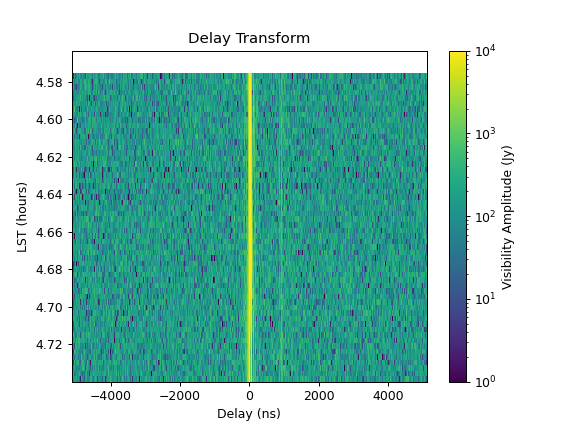

In [28]:
bl = (65,71,'xx')

# your answer here
df = delay_filter.DelayFilter(hd) # establish delay filter object
df.run_filter(to_filter=[bl], min_dly=6000) # try to over all delays

vis = df.clean_data[bl] 
vis_dt = np.fft.fftshift(np.fft.fft(vis, axis=1), axes=1) # Fourier-transform along frequency
freq_width =  np.median(np.diff(hd.freqs)) / 1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(len(hd.freqs), freq_width)) # ns

plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e4), interpolation='none',
           extent=(np.min(delays), np.max(delays),
                   hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');